<a href="https://colab.research.google.com/github/wyctorfogos/GAN_using_MNIST_dataset/blob/main/GAN_cycle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.datasets import mnist
import numpy as np

In [2]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


Normalize dataset

In [3]:
x_train, x_test=x_train/255., x_test/255.


In [4]:
x_train.shape

(60000, 28, 28)

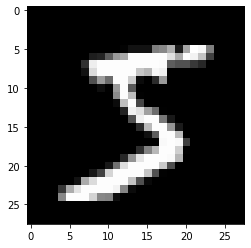

In [5]:
import matplotlib.pyplot as plt 

plt.imshow(x_train[0], cmap='gray')
plt.show()

GAN system

In [149]:

class Generator():
  def __init__(self, input_dimensions=(28,28,1),noise_vector_shape=(int(28*28),)):
    self.input_dimensions=input_dimensions ##Images dimensions
    self.noise_vector_shape=noise_vector_shape
    pass

  def Generator_model(self):

    model= keras.Sequential()
    model.add(keras.layers.Dense(28*28, input_shape=self.noise_vector_shape))
    model.add(keras.layers.ReLU())
    model.add(keras.layers.Dense(28*28*2))
    model.add(keras.layers.ReLU())
    model.add(keras.layers.Dense(28*28*4))
    model.add(keras.layers.ReLU())
    model.add(keras.layers.Dense(28*28*1))
    model.add(keras.layers.Reshape(self.input_dimensions))

    input=keras.Input(shape=self.noise_vector_shape)
    
    generator_model=keras.Model(input,model(input))

    print("Generator")
    print(generator_model.summary())
    return  generator_model

In [219]:
GENERATOR=Generator(input_dimensions=(28,28,1),noise_vector_shape=(100,)).Generator_model()

Generator
Model: "model_108"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_119 (InputLayer)      [(None, 100)]             0         
                                                                 
 sequential_64 (Sequential)  (None, 28, 28, 1)         8689856   
                                                                 
Total params: 8,689,856
Trainable params: 8,689,856
Non-trainable params: 0
_________________________________________________________________
None


In [172]:
import numpy as np

#noise_array=np.random.random()
#img_withnoise=imgs.ravel()+noise_array
#print(img_withnoise)

In [152]:
#print(np.array(abs(GENERATOR.predict(np.expand_dims(noise_array,axis=0)))).shape)
np.expand_dims(x_train, axis=3).shape

(60000, 28, 28, 1)

In [218]:
from keras.applications.vgg19 import VGG19
from keras.layers import Input, Lambda, Dense, Flatten

class Discriminator():
  def __init__(self,input_image_shape=(28,28,1)):
    self.input_image_shape=input_image_shape

    pass
  def Discriminator_model(self):
    
    #vgg19_part=VGG19(include_top=False, weights='imagenet', input_shape=self.input_image_shape, classes=1)

    #x = Flatten()(vgg19_part.output) #Output obtained on vgg16 is now flattened. 
    #prediction = Dense(1, activation='sigmoid')(x) # We have 5 classes, and so, the prediction is being done on len(folders) - 5 classes#Creating model object 
    model=keras.Sequential()

    model.add(keras.layers.Dense(28*28, input_shape=self.input_image_shape))
    model.add(keras.layers.ReLU())
    model.add(keras.layers.Dense(28*28*2))
    model.add(keras.layers.ReLU())
    model.add(keras.layers.Dense(28*28*4))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(1, activation='sigmoid'))


    input=keras.Input(shape=self.input_image_shape)
    prediction=model(input)
    model = keras.Model(inputs=input, outputs=prediction)
    
    print("Discriminator")
    print(model.summary())

    return model

In [11]:
DISCRIMINATOR=Discriminator(input_image_shape=(28,28,1)).Discriminator_model()

Discriminator
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 sequential_1 (Sequential)   (None, 1)                 8611457   
                                                                 
Total params: 8,611,457
Trainable params: 8,611,457
Non-trainable params: 0
_________________________________________________________________
None


In [211]:
def GAN_MODEL(generator=GENERATOR, discriminator=DISCRIMINATOR):
  #generated_image = generator(input_GAN_system)

  #validat_image = discriminator(generated_image)
  #GAN_combination = keras.Model(input_GAN_system, validat_image)
  #GAN_combination.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=1e-4))
  #print("GAN system model")
  
  discriminator.trainable=False

  GAN_combination=keras.Sequential()
  GAN_combination.add(generator)
  GAN_combination.add(discriminator)

  print(GAN_combination.summary())

  GAN_MODEL=GAN_combination

  return GAN_combination

In [212]:
#del GAN_combination

GAN_combination=GAN_MODEL(generator=GENERATOR, discriminator=DISCRIMINATOR)


Model: "sequential_55"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_96 (Functional)       (None, 28, 28, 1)         28280448  
                                                                 
 model_1 (Functional)        (None, 1)                 8611457   
                                                                 
Total params: 36,891,905
Trainable params: 28,280,448
Non-trainable params: 8,611,457
_________________________________________________________________
None


In [177]:
batch_size=64
half_batch = int(batch_size / 2)

In [178]:
noise = np.random.randint(0, 1, (batch_size, 28*28))
print(noise.shape)

(64, 784)


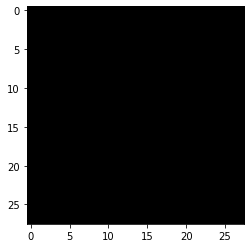

In [140]:
import cv2

generated_image=abs(GENERATOR.predict(noise))*255.0
generated_image= cv2.cvtColor(generated_image[1], cv2.COLOR_BGR2RGB)
plt.imshow(generated_image)
plt.show()


In [223]:
def train_GAN(x_train,DISCRIMINATOR, GENERATOR, batch_size):
  epochs=1000

  x_train=np.expand_dims(x_train,axis=3)
  
  for epoch in range(epochs):
    print("Epoch {}".format(epoch))
    idx = np.random.randint(0, x_train.shape[0], half_batch)
    imgs = x_train[idx]

    ##To be used into Discriminator train process
    noise = np.random.normal(0, 1, (half_batch, 100))

    gen_imgs = GENERATOR.predict(noise)
    
    ##It is necessary to get the DISCRIMINATOR's loss value 
    with tf.device('/device:GPU:0'):
      d_loss_real = DISCRIMINATOR.train_on_batch(imgs, np.ones((half_batch, 1)))
      d_loss_fake = DISCRIMINATOR.train_on_batch(gen_imgs, np.zeros((half_batch, 1)))

    d_loss=0.5*np.add(d_loss_real,d_loss_fake)
    print(d_loss)

    DISCRIMINATOR.trainable=True

    ##Test the generator model
    noise = np.random.randint(0, 1, (batch_size, 100))

    noise = np.random.normal(0, 1, (batch_size, 100)) 

    # The generator wants the discriminator to label the generated samples
    # as valid (ones)
    #This is where the genrator is trying to trick discriminator into believing
    #the generated image is true (hence value of 1 for y)
    valid_y = np.array([1] * batch_size) #Creates an array of all ones of size=batch size

    # Generator is part of combined where it got directly linked with the discriminator
    # Train the generator with noise as x and 1 as y. 
    # Again, 1 as the output as it is adversarial and if generator did a great
    #job of folling the discriminator then the output would be 1 (true)
    with tf.device('/device:GPU:0'):
      g_loss = GAN_combination.train_on_batch(noise, valid_y)
    
    #g_loss = GENERATOR.train_on_batch(noise)
    
    if epoch%10==0:
      try:
        print("Saving generator model")
        GENERATOR.save("./generators/gen_epoch_{}.h5".format(epoch))
        print("Saved!")
        plot_images(GENERATOR)
      except:
        print("Try to save the last trained model again!")

Discriminator
Model: "model_115"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_126 (InputLayer)      [(None, 28, 28, 1)]       0         
                                                                 
 sequential_69 (Sequential)  (None, 1)                 8611457   
                                                                 
Total params: 8,611,457
Trainable params: 8,611,457
Non-trainable params: 0
_________________________________________________________________
None
Generator
Model: "model_116"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_127 (InputLayer)      [(None, 100)]             0         
                                                                 
 sequential_70 (Sequential)  (None, 28, 28, 1)         8689856   
                                                                 

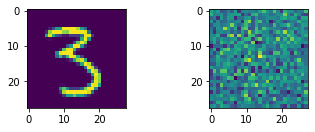

Epoch 1
[0.567986 0.828125]
Epoch 2
[0.48782817 1.        ]
Epoch 3
[0.45759971 0.875     ]
Epoch 4
[0.43453722 0.828125  ]
Epoch 5
[0.40095677 0.96875   ]
Epoch 6
[0.32985325 1.        ]
Epoch 7
[0.22440506 1.        ]
Epoch 8
[0.22837938 0.984375  ]
Epoch 9
[0.21736626 0.9375    ]
Epoch 10
[0.25643289 0.953125  ]
Saving generator model
Saved!
(28, 28)


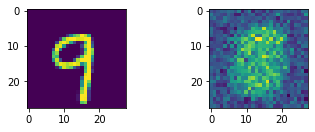

Epoch 11
[0.25389406 0.953125  ]
Epoch 12
[0.2043246 1.       ]
Epoch 13
[0.15070185 1.        ]
Epoch 14
[0.12184552 0.984375  ]
Epoch 15
[0.20244692 0.953125  ]
Epoch 16
[0.24930264 0.921875  ]
Epoch 17
[0.23440693 0.96875   ]
Epoch 18
[0.28657749 0.9375    ]
Epoch 19
[0.1586414 0.984375 ]
Epoch 20
[0.14210991 0.96875   ]
Saving generator model
Saved!
(28, 28)


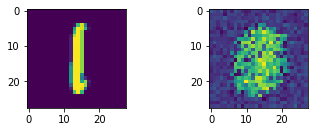

Epoch 21
[0.1296452 0.96875  ]
Epoch 22
[0.12029092 0.984375  ]
Epoch 23
[0.09791982 0.96875   ]
Epoch 24
[0.07207853 0.984375  ]
Epoch 25
[0.05107668 1.        ]
Epoch 26
[0.0313825 1.       ]
Epoch 27
[0.04532853 0.984375  ]
Epoch 28
[0.03257072 1.        ]
Epoch 29
[0.016865 1.      ]
Epoch 30
[0.02170049 1.        ]
Saving generator model
Saved!
(28, 28)


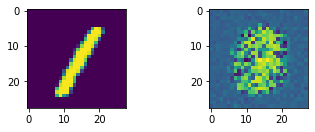

Epoch 31
[0.00943048 1.        ]
Epoch 32
[0.01264393 1.        ]
Epoch 33
[0.00797584 1.        ]
Epoch 34
[0.00622298 1.        ]
Epoch 35
[0.01247316 1.        ]
Epoch 36
[0.0093878 1.       ]
Epoch 37
[0.00767035 1.        ]
Epoch 38
[0.0097887 1.       ]
Epoch 39
[0.00562296 1.        ]
Epoch 40
[0.00453717 1.        ]
Saving generator model
Saved!
(28, 28)


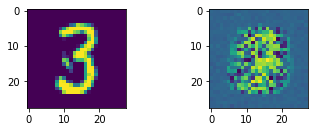

Epoch 41
[0.01386303 1.        ]
Epoch 42
[0.00527558 1.        ]
Epoch 43
[0.00614759 1.        ]
Epoch 44
[0.00610008 1.        ]
Epoch 45
[0.00419474 1.        ]
Epoch 46
[0.00442896 1.        ]
Epoch 47
[0.00262667 1.        ]
Epoch 48
[0.00331649 1.        ]
Epoch 49
[0.00127014 1.        ]
Epoch 50
[0.00113348 1.        ]
Saving generator model
Saved!
(28, 28)


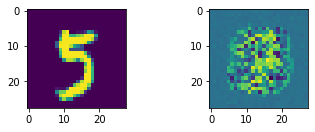

Epoch 51
[0.00112022 1.        ]
Epoch 52
[0.00121871 1.        ]
Epoch 53
[0.00224356 1.        ]
Epoch 54
[0.00164031 1.        ]
Epoch 55
[0.00227941 1.        ]
Epoch 56
[9.10352159e-04 1.00000000e+00]
Epoch 57
[0.0013765 1.       ]
Epoch 58
[0.00103221 1.        ]
Epoch 59
[0.00122855 1.        ]
Epoch 60
[0.0017698 1.       ]
Saving generator model
Saved!
(28, 28)


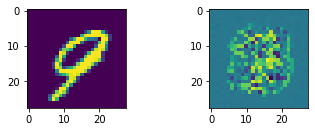

Epoch 61
[8.86930444e-04 1.00000000e+00]
Epoch 62
[0.00190618 1.        ]
Epoch 63
[0.00128006 1.        ]
Epoch 64
[7.0542394e-04 1.0000000e+00]
Epoch 65
[0.00216988 1.        ]
Epoch 66
[0.0017136 1.       ]
Epoch 67
[0.00108432 1.        ]
Epoch 68
[0.0019815 1.       ]
Epoch 69
[6.35147881e-04 1.00000000e+00]
Epoch 70
[0.00144172 1.        ]
Saving generator model
Saved!
(28, 28)


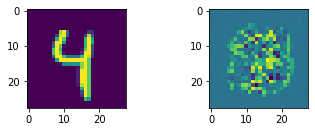

Epoch 71
[0.00257224 1.        ]
Epoch 72
[7.61709118e-04 1.00000000e+00]
Epoch 73
[0.00161287 1.        ]
Epoch 74
[7.77017543e-04 1.00000000e+00]
Epoch 75
[6.03858527e-04 1.00000000e+00]
Epoch 76
[4.17297357e-04 1.00000000e+00]
Epoch 77
[4.81893701e-04 1.00000000e+00]
Epoch 78
[8.05704884e-04 1.00000000e+00]
Epoch 79
[4.92236359e-04 1.00000000e+00]
Epoch 80
[7.74467742e-04 1.00000000e+00]
Saving generator model
Saved!
(28, 28)


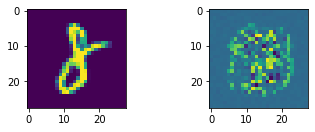

Epoch 81
[0.00146406 1.        ]
Epoch 82
[0.00103575 1.        ]
Epoch 83
[7.55892368e-04 1.00000000e+00]
Epoch 84
[8.43255431e-04 1.00000000e+00]
Epoch 85
[5.81846572e-04 1.00000000e+00]
Epoch 86
[6.85730731e-04 1.00000000e+00]
Epoch 87
[0.00166593 1.        ]
Epoch 88
[6.48956993e-04 1.00000000e+00]
Epoch 89
[4.79679657e-04 1.00000000e+00]
Epoch 90
[9.87540174e-04 1.00000000e+00]
Saving generator model
Saved!
(28, 28)


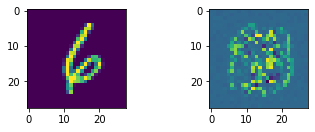

Epoch 91
[7.65681471e-04 1.00000000e+00]
Epoch 92
[0.00143385 1.        ]
Epoch 93
[7.32214306e-04 1.00000000e+00]
Epoch 94
[0.00109669 1.        ]
Epoch 95
[0.00124198 1.        ]
Epoch 96
[0.00220809 1.        ]
Epoch 97
[0.00119106 1.        ]
Epoch 98
[0.00146139 1.        ]
Epoch 99
[0.00271547 1.        ]
Epoch 100
[0.00313044 1.        ]
Saving generator model
Saved!
(28, 28)


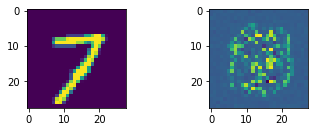

Epoch 101
[0.00112046 1.        ]
Epoch 102
[0.00320664 1.        ]
Epoch 103
[0.00380437 1.        ]
Epoch 104
[0.00378488 1.        ]
Epoch 105
[0.0030241 1.       ]
Epoch 106
[0.00488794 1.        ]
Epoch 107
[0.00577901 1.        ]
Epoch 108
[0.00326014 1.        ]
Epoch 109
[0.00210044 1.        ]
Epoch 110
[0.00418245 1.        ]
Saving generator model
Saved!
(28, 28)


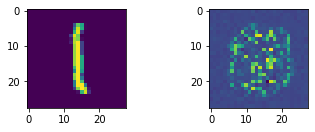

Epoch 111
[0.02035831 1.        ]
Epoch 112
[0.01835957 1.        ]
Epoch 113
[0.00404266 1.        ]
Epoch 114
[0.01905253 1.        ]
Epoch 115
[0.00604191 1.        ]
Epoch 116
[0.00595623 1.        ]
Epoch 117
[0.00502798 1.        ]
Epoch 118
[0.00525658 1.        ]
Epoch 119
[0.0028156 1.       ]
Epoch 120
[0.00655266 1.        ]
Saving generator model
Saved!
(28, 28)


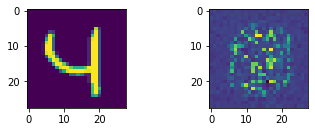

Epoch 121
[0.01012781 1.        ]
Epoch 122
[0.00835873 1.        ]
Epoch 123
[0.01240519 1.        ]
Epoch 124
[0.00376899 1.        ]
Epoch 125
[0.00809623 1.        ]
Epoch 126
[0.04710955 0.984375  ]
Epoch 127
[0.01630819 1.        ]
Epoch 128
[0.01447377 1.        ]
Epoch 129
[0.04239692 0.96875   ]
Epoch 130
[0.02207237 1.        ]
Saving generator model
Saved!
(28, 28)


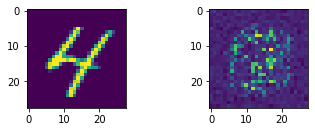

Epoch 131
[0.00962698 1.        ]
Epoch 132
[0.01099442 1.        ]
Epoch 133
[0.01534855 1.        ]
Epoch 134
[0.01280147 1.        ]
Epoch 135
[0.00926595 1.        ]
Epoch 136
[0.00767408 1.        ]
Epoch 137
[0.00588199 1.        ]
Epoch 138
[0.00902019 1.        ]
Epoch 139
[0.00924241 1.        ]
Epoch 140
[0.00757642 1.        ]
Saving generator model
Saved!
(28, 28)


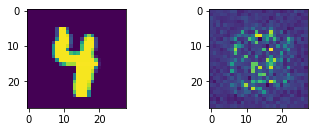

Epoch 141
[0.00935307 1.        ]
Epoch 142
[0.00450815 1.        ]
Epoch 143
[0.00613005 1.        ]
Epoch 144
[0.00647081 1.        ]
Epoch 145
[0.00789538 1.        ]
Epoch 146
[0.01024117 1.        ]
Epoch 147
[0.00715438 1.        ]
Epoch 148
[0.00603442 1.        ]
Epoch 149
[0.00569129 1.        ]
Epoch 150
[0.01021169 1.        ]
Saving generator model
Saved!
(28, 28)


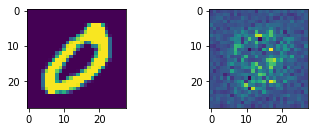

Epoch 151
[0.00697725 1.        ]
Epoch 152
[0.00709246 1.        ]
Epoch 153
[0.00606769 1.        ]
Epoch 154
[0.00797296 1.        ]
Epoch 155
[0.00824982 1.        ]
Epoch 156
[0.004659 1.      ]
Epoch 157
[0.00951708 1.        ]
Epoch 158
[0.01038843 1.        ]
Epoch 159
[0.01110094 1.        ]
Epoch 160
[0.00551514 1.        ]
Saving generator model
Saved!
(28, 28)


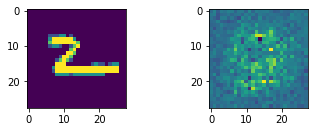

Epoch 161
[0.00480893 1.        ]
Epoch 162
[0.01089823 1.        ]
Epoch 163
[0.00563809 1.        ]
Epoch 164
[0.00386404 1.        ]
Epoch 165
[0.00336878 1.        ]
Epoch 166
[0.00910295 1.        ]
Epoch 167
[0.00241485 1.        ]
Epoch 168
[0.00235527 1.        ]
Epoch 169
[0.00308886 1.        ]
Epoch 170
[0.00401874 1.        ]
Saving generator model
Saved!
(28, 28)


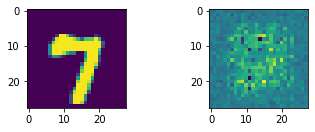

Epoch 171
[0.0022114 1.       ]
Epoch 172
[0.00149686 1.        ]
Epoch 173
[0.03574536 0.984375  ]
Epoch 174
[0.0159455 1.       ]
Epoch 175
[0.00418285 1.        ]
Epoch 176
[0.01679727 0.984375  ]
Epoch 177
[0.00206084 1.        ]
Epoch 178
[0.0021091 1.       ]
Epoch 179
[9.59496259e-04 1.00000000e+00]
Epoch 180
[0.0012971 1.       ]
Saving generator model
Saved!
(28, 28)


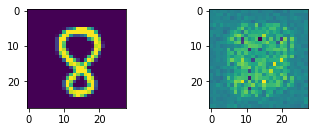

Epoch 181
[0.00188792 1.        ]
Epoch 182
[0.00265226 1.        ]
Epoch 183
[0.00854194 1.        ]
Epoch 184
[0.00402212 1.        ]
Epoch 185
[0.00429743 1.        ]
Epoch 186
[0.0023568 1.       ]
Epoch 187
[0.00101879 1.        ]
Epoch 188
[0.0026607 1.       ]
Epoch 189
[8.96862766e-04 1.00000000e+00]
Epoch 190
[0.00295001 1.        ]
Saving generator model
Saved!
(28, 28)


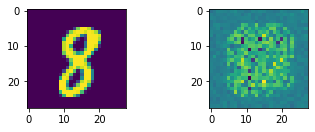

Epoch 191
[3.45838158e-04 1.00000000e+00]
Epoch 192
[0.00569412 1.        ]
Epoch 193
[0.00156888 1.        ]
Epoch 194
[0.00182661 1.        ]
Epoch 195
[0.00236921 1.        ]
Epoch 196
[0.00159594 1.        ]
Epoch 197
[9.66296827e-04 1.00000000e+00]
Epoch 198
[5.67979444e-04 1.00000000e+00]
Epoch 199
[4.65119447e-04 1.00000000e+00]
Epoch 200
[0.00258394 1.        ]
Saving generator model
Saved!
(28, 28)


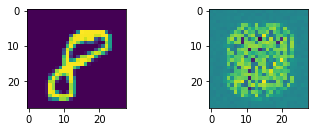

Epoch 201
[2.88697333e-04 1.00000000e+00]
Epoch 202
[7.42192206e-04 1.00000000e+00]
Epoch 203
[3.38633777e-04 1.00000000e+00]
Epoch 204
[3.20145623e-04 1.00000000e+00]
Epoch 205
[3.72658171e-04 1.00000000e+00]
Epoch 206
[5.86809911e-04 1.00000000e+00]
Epoch 207
[4.0026053e-04 1.0000000e+00]
Epoch 208
[5.405673e-04 1.000000e+00]
Epoch 209
[4.3055153e-04 1.0000000e+00]
Epoch 210
[0.0018333 1.       ]
Saving generator model
Saved!
(28, 28)


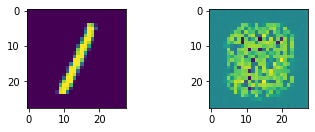

Epoch 211
[6.81740095e-04 1.00000000e+00]
Epoch 212
[8.46652989e-04 1.00000000e+00]
Epoch 213
[8.63385605e-04 1.00000000e+00]
Epoch 214
[9.47796491e-04 1.00000000e+00]
Epoch 215
[0.00336953 1.        ]
Epoch 216
[0.00185297 1.        ]
Epoch 217
[0.00100776 1.        ]
Epoch 218
[0.00164056 1.        ]
Epoch 219
[0.00217795 1.        ]
Epoch 220
[0.00209911 1.        ]
Saving generator model
Saved!
(28, 28)


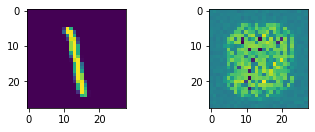

Epoch 221
[0.01390417 1.        ]
Epoch 222
[0.00448881 1.        ]
Epoch 223
[0.0183243 1.       ]
Epoch 224
[0.17659602 0.9375    ]
Epoch 225
[0.13137321 0.9375    ]
Epoch 226
[0.15721334 0.9375    ]
Epoch 227
[0.08757124 0.96875   ]
Epoch 228
[0.09200604 0.953125  ]
Epoch 229
[0.228056 0.875   ]
Epoch 230
[0.04918368 0.96875   ]
Saving generator model
Saved!
(28, 28)


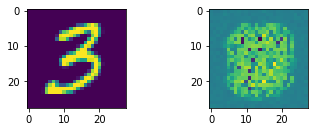

Epoch 231
[0.18125337 0.953125  ]
Epoch 232
[0.06218108 0.953125  ]
Epoch 233
[0.03681558 0.984375  ]
Epoch 234
[0.00213964 1.        ]
Epoch 235
[9.01251682e-04 1.00000000e+00]
Epoch 236
[2.61973053e-04 1.00000000e+00]
Epoch 237
[0.01186535 1.        ]
Epoch 238
[0.0078929 1.       ]
Epoch 239
[0.0108602 1.       ]
Epoch 240
[2.48860651e-04 1.00000000e+00]
Saving generator model
Saved!
(28, 28)


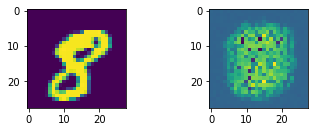

Epoch 241
[2.68636596e-04 1.00000000e+00]
Epoch 242
[1.69793526e-04 1.00000000e+00]
Epoch 243
[2.49217836e-04 1.00000000e+00]
Epoch 244
[0.00741087 1.        ]
Epoch 245
[0.02411918 1.        ]
Epoch 246
[0.13456742 0.984375  ]
Epoch 247
[0.00266099 1.        ]
Epoch 248
[0.05673559 0.984375  ]
Epoch 249
[0.00801934 1.        ]
Epoch 250
[0.04501997 0.984375  ]
Saving generator model
Saved!
(28, 28)


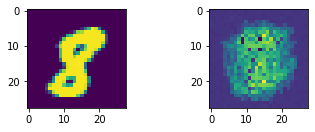

Epoch 251
[0.00210983 1.        ]
Epoch 252
[0.00795278 1.        ]
Epoch 253
[0.0637806 1.       ]
Epoch 254
[0.00290424 1.        ]
Epoch 255
[0.25531222 0.890625  ]
Epoch 256
[0.03760023 1.        ]
Epoch 257
[0.03845195 1.        ]
Epoch 258
[6.29904069e-04 1.00000000e+00]
Epoch 259
[0.00534489 1.        ]
Epoch 260
[0.04854933 1.        ]
Saving generator model
Saved!
(28, 28)


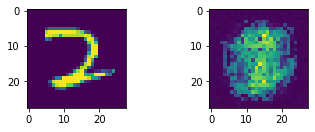

Epoch 261
[0.00423915 1.        ]
Epoch 262
[9.26641136e-04 1.00000000e+00]
Epoch 263
[0.00249369 1.        ]
Epoch 264
[0.02340122 1.        ]
Epoch 265
[0.00690736 1.        ]
Epoch 266
[0.00162306 1.        ]
Epoch 267
[0.00171692 1.        ]
Epoch 268
[0.00996701 1.        ]
Epoch 269
[0.00469794 1.        ]
Epoch 270
[0.00663024 1.        ]
Saving generator model
Saved!
(28, 28)


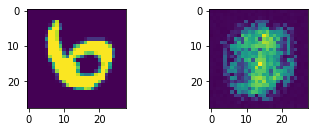

Epoch 271
[0.0081406 1.       ]
Epoch 272
[0.016149 1.      ]
Epoch 273
[0.02825537 0.984375  ]
Epoch 274
[0.07971474 0.984375  ]
Epoch 275
[0.0719962 0.984375 ]
Epoch 276
[0.03845735 0.984375  ]
Epoch 277
[0.15905991 0.90625   ]
Epoch 278
[0.05353837 1.        ]
Epoch 279
[0.2162841 0.875    ]
Epoch 280
[0.09256692 0.96875   ]
Saving generator model
Saved!
(28, 28)


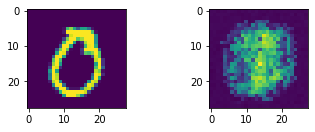

Epoch 281
[0.29290396 0.890625  ]
Epoch 282
[0.20375229 0.9375    ]
Epoch 283
[0.07156533 0.96875   ]
Epoch 284
[0.37308507 0.859375  ]
Epoch 285
[0.44309657 0.8125    ]
Epoch 286
[0.0142522 1.       ]
Epoch 287
[0.18648318 0.921875  ]
Epoch 288
[0.17388436 0.96875   ]
Epoch 289
[0.0446804 0.984375 ]
Epoch 290
[0.06877221 1.        ]
Saving generator model
Saved!
(28, 28)


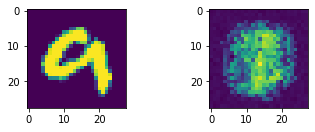

Epoch 291
[0.04638657 1.        ]
Epoch 292
[0.01520193 1.        ]
Epoch 293
[0.00806571 1.        ]
Epoch 294
[0.04112272 0.984375  ]
Epoch 295
[0.01972994 0.984375  ]
Epoch 296
[0.0408002 0.96875  ]
Epoch 297
[0.01103215 1.        ]
Epoch 298
[0.01524471 1.        ]
Epoch 299
[0.01426486 1.        ]
Epoch 300
[0.01003244 1.        ]
Saving generator model
Saved!
(28, 28)


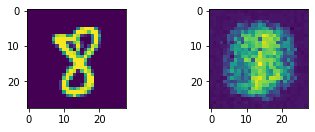

Epoch 301
[0.00531655 1.        ]
Epoch 302
[0.00416215 1.        ]
Epoch 303
[0.00334155 1.        ]
Epoch 304
[0.02801977 0.984375  ]
Epoch 305
[0.00600196 1.        ]
Epoch 306
[0.0025657 1.       ]
Epoch 307
[0.00410767 1.        ]
Epoch 308
[0.0030048 1.       ]
Epoch 309
[0.0029253 1.       ]
Epoch 310
[0.00480018 1.        ]
Saving generator model
Saved!
(28, 28)


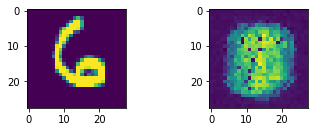

Epoch 311
[0.00832004 1.        ]
Epoch 312
[0.00282139 1.        ]
Epoch 313
[0.00264391 1.        ]
Epoch 314
[0.00287548 1.        ]
Epoch 315
[0.00501056 1.        ]
Epoch 316
[0.00207284 1.        ]
Epoch 317
[0.00234013 1.        ]
Epoch 318
[0.00155211 1.        ]
Epoch 319
[0.00143265 1.        ]
Epoch 320
[0.00124557 1.        ]
Saving generator model
Saved!
(28, 28)


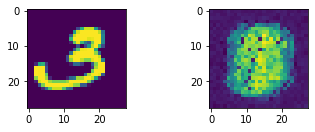

Epoch 321
[0.00134304 1.        ]
Epoch 322
[0.00235037 1.        ]
Epoch 323
[9.37007339e-04 1.00000000e+00]
Epoch 324
[0.00124771 1.        ]
Epoch 325
[0.0021296 1.       ]
Epoch 326
[0.00446117 1.        ]
Epoch 327
[0.00107845 1.        ]
Epoch 328
[0.00173959 1.        ]
Epoch 329
[0.00119405 1.        ]
Epoch 330
[0.00428492 1.        ]
Saving generator model
Saved!
(28, 28)


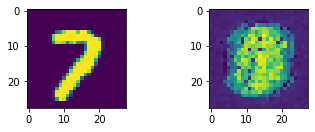

Epoch 331
[0.00414718 1.        ]
Epoch 332
[0.00172848 1.        ]
Epoch 333
[0.00203026 1.        ]
Epoch 334
[0.00429016 1.        ]
Epoch 335
[0.0019961 1.       ]
Epoch 336
[0.01680425 0.984375  ]
Epoch 337
[0.00454363 1.        ]
Epoch 338
[0.00428399 1.        ]
Epoch 339
[0.00394256 1.        ]
Epoch 340
[0.00429578 1.        ]
Saving generator model
Saved!
(28, 28)


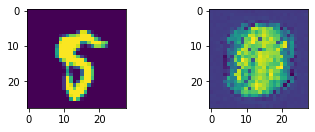

Epoch 341
[0.00273567 1.        ]
Epoch 342
[0.00196983 1.        ]
Epoch 343
[0.00317752 1.        ]
Epoch 344
[0.00340419 1.        ]
Epoch 345
[0.00150935 1.        ]
Epoch 346
[0.00334266 1.        ]
Epoch 347
[0.00130273 1.        ]
Epoch 348
[0.001179 1.      ]
Epoch 349
[9.70359435e-04 1.00000000e+00]
Epoch 350
[0.00196423 1.        ]
Saving generator model
Saved!
(28, 28)


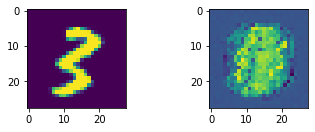

Epoch 351
[9.75019786e-04 1.00000000e+00]
Epoch 352
[0.00149934 1.        ]
Epoch 353
[0.00354262 1.        ]
Epoch 354
[0.00584608 1.        ]
Epoch 355
[0.00188336 1.        ]
Epoch 356
[0.00187582 1.        ]
Epoch 357
[0.00207055 1.        ]
Epoch 358
[0.00214433 1.        ]
Epoch 359
[0.00194625 1.        ]
Epoch 360
[0.0037609 1.       ]
Saving generator model
Saved!
(28, 28)


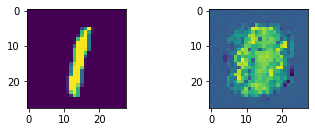

Epoch 361
[0.02442849 0.984375  ]
Epoch 362
[0.00455925 1.        ]
Epoch 363
[0.00942478 1.        ]
Epoch 364
[0.00661451 1.        ]
Epoch 365
[0.00644962 1.        ]
Epoch 366
[0.00330853 1.        ]
Epoch 367
[0.01050279 1.        ]
Epoch 368
[0.00215777 1.        ]
Epoch 369
[0.00162699 1.        ]
Epoch 370
[0.00169081 1.        ]
Saving generator model
Saved!
(28, 28)


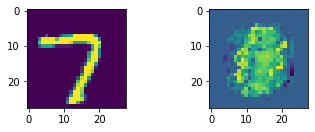

Epoch 371
[0.0176271 0.984375 ]
Epoch 372
[0.00292038 1.        ]
Epoch 373
[0.00374327 1.        ]
Epoch 374
[0.00352415 1.        ]
Epoch 375
[0.00318861 1.        ]
Epoch 376
[0.00370335 1.        ]
Epoch 377
[0.00216108 1.        ]
Epoch 378
[0.00212209 1.        ]
Epoch 379
[0.01297164 1.        ]
Epoch 380
[0.0031122 1.       ]
Saving generator model
Saved!
(28, 28)


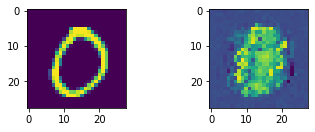

Epoch 381
[0.00406294 1.        ]
Epoch 382
[0.00371088 1.        ]
Epoch 383
[0.00273202 1.        ]
Epoch 384
[0.00223162 1.        ]
Epoch 385
[0.00634376 1.        ]
Epoch 386
[0.00485384 1.        ]
Epoch 387
[0.0029818 1.       ]
Epoch 388
[0.00391636 1.        ]
Epoch 389
[0.00615572 1.        ]
Epoch 390
[0.00483084 1.        ]
Saving generator model
Saved!
(28, 28)


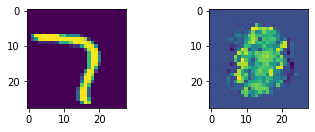

Epoch 391
[0.0117174 1.       ]
Epoch 392
[0.0049251 1.       ]
Epoch 393
[0.03158093 0.984375  ]
Epoch 394
[0.0184423 1.       ]
Epoch 395
[0.00890005 1.        ]
Epoch 396
[0.00670815 1.        ]
Epoch 397
[0.00621898 1.        ]
Epoch 398
[0.00367017 1.        ]
Epoch 399
[0.01924439 0.984375  ]
Epoch 400
[0.01282539 1.        ]
Saving generator model
Saved!
(28, 28)


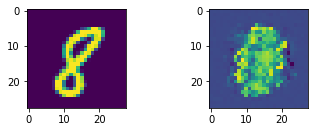

Epoch 401
[0.01145638 1.        ]
Epoch 402
[0.01230689 1.        ]
Epoch 403
[0.00347039 1.        ]
Epoch 404
[0.00198846 1.        ]
Epoch 405
[0.0118939 1.       ]
Epoch 406
[0.00403313 1.        ]
Epoch 407
[0.00184543 1.        ]
Epoch 408
[0.00563882 1.        ]
Epoch 409
[0.02489706 0.984375  ]
Epoch 410
[0.01308204 1.        ]
Saving generator model
Saved!
(28, 28)


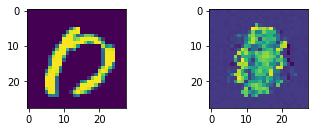

Epoch 411
[0.00668351 1.        ]
Epoch 412
[0.02222635 0.984375  ]
Epoch 413
[0.01134144 1.        ]
Epoch 414
[0.00924224 1.        ]
Epoch 415
[0.03746396 0.984375  ]
Epoch 416
[0.01545252 1.        ]
Epoch 417
[0.02762495 1.        ]
Epoch 418
[0.07419239 0.96875   ]
Epoch 419
[0.01947509 1.        ]
Epoch 420
[0.05076614 0.984375  ]
Saving generator model
Saved!
(28, 28)


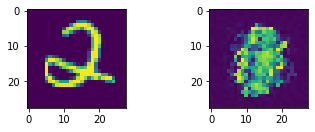

Epoch 421
[0.43748891 0.734375  ]
Epoch 422
[0.20687652 0.953125  ]
Epoch 423
[0.07770805 0.953125  ]
Epoch 424
[0.20298403 0.90625   ]
Epoch 425
[0.00809489 1.        ]
Epoch 426
[1.0592389 0.5625   ]
Epoch 427
[4.7057678 0.5      ]
Epoch 428
[0.00244884 1.        ]
Epoch 429
[0.0014377 1.       ]
Epoch 430
[0.18078104 0.90625   ]
Saving generator model
Saved!
(28, 28)


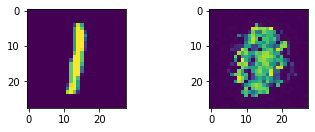

Epoch 431
[0.35646158 0.84375   ]
Epoch 432
[0.03975349 0.984375  ]
Epoch 433
[0.00294108 1.        ]
Epoch 434
[1.87491553e-04 1.00000000e+00]
Epoch 435
[4.32344991e-04 1.00000000e+00]
Epoch 436
[1.24238569e-04 1.00000000e+00]
Epoch 437
[5.36016124e-05 1.00000000e+00]
Epoch 438
[4.54317716e-06 1.00000000e+00]
Epoch 439
[2.38569061e-06 1.00000000e+00]
Epoch 440
[1.14622375e-05 1.00000000e+00]
Saving generator model
Saved!
(28, 28)


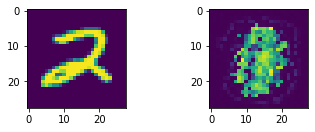

Epoch 441
[0.0012682 1.       ]
Epoch 442
[3.97889215e-06 1.00000000e+00]
Epoch 443
[5.78044535e-06 1.00000000e+00]
Epoch 444
[1.25321742e-05 1.00000000e+00]
Epoch 445
[3.00598497e-05 1.00000000e+00]
Epoch 446
[5.51610363e-05 1.00000000e+00]
Epoch 447
[9.64233685e-05 1.00000000e+00]
Epoch 448
[1.54673463e-04 1.00000000e+00]
Epoch 449
[2.99871018e-04 1.00000000e+00]
Epoch 450
[5.11831628e-04 1.00000000e+00]
Saving generator model
Saved!
(28, 28)


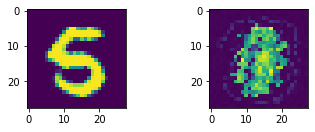

Epoch 451
[7.38062793e-04 1.00000000e+00]
Epoch 452
[0.00113358 1.        ]
Epoch 453
[0.00172566 1.        ]
Epoch 454
[0.00218197 1.        ]
Epoch 455
[0.00313371 1.        ]
Epoch 456
[0.00399511 1.        ]
Epoch 457
[0.00468499 1.        ]
Epoch 458
[0.00517358 1.        ]
Epoch 459
[0.00551132 1.        ]
Epoch 460
[0.00544959 1.        ]
Saving generator model
Saved!
(28, 28)


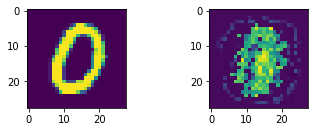

Epoch 461
[0.00512258 1.        ]
Epoch 462
[0.00455792 1.        ]
Epoch 463
[0.00390622 1.        ]
Epoch 464
[0.00334792 1.        ]
Epoch 465
[0.00303801 1.        ]
Epoch 466
[0.00294176 1.        ]
Epoch 467
[0.00290419 1.        ]
Epoch 468
[0.00258796 1.        ]
Epoch 469
[0.00226745 1.        ]
Epoch 470
[0.00222806 1.        ]
Saving generator model
Saved!
(28, 28)


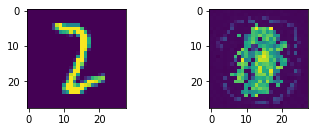

Epoch 471
[0.00303308 1.        ]
Epoch 472
[0.00253887 1.        ]
Epoch 473
[0.00228702 1.        ]
Epoch 474
[0.00362887 1.        ]
Epoch 475
[0.00306767 1.        ]
Epoch 476
[0.00412329 1.        ]
Epoch 477
[0.00256082 1.        ]
Epoch 478
[0.0066819 1.       ]
Epoch 479
[0.00656749 1.        ]
Epoch 480
[0.01495159 1.        ]
Saving generator model
Saved!
(28, 28)


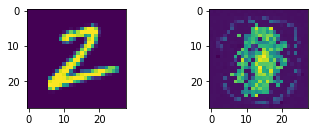

Epoch 481
[0.01242343 1.        ]
Epoch 482
[0.00881804 1.        ]
Epoch 483
[0.01137403 1.        ]
Epoch 484
[0.00835758 1.        ]
Epoch 485
[0.03027794 0.984375  ]
Epoch 486
[0.00865213 1.        ]
Epoch 487
[0.01199363 1.        ]
Epoch 488
[0.00805537 1.        ]
Epoch 489
[0.00821009 1.        ]
Epoch 490
[0.0411394 0.96875  ]
Saving generator model
Saved!
(28, 28)


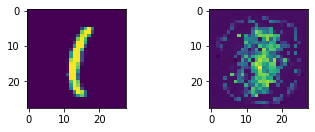

Epoch 491
[0.03267665 0.984375  ]
Epoch 492
[0.0138038 1.       ]
Epoch 493
[0.05940111 0.96875   ]
Epoch 494
[0.02016976 1.        ]
Epoch 495
[0.05173916 0.984375  ]
Epoch 496
[0.01983301 1.        ]
Epoch 497
[0.03140924 0.984375  ]
Epoch 498
[0.01036997 1.        ]
Epoch 499
[0.00898146 1.        ]
Epoch 500
[0.0120769 1.       ]
Saving generator model
Saved!
(28, 28)


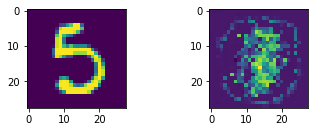

Epoch 501
[0.02071303 0.984375  ]
Epoch 502
[0.00468318 1.        ]
Epoch 503
[0.0121278 1.       ]
Epoch 504
[0.02964969 0.984375  ]
Epoch 505
[0.03090368 0.984375  ]
Epoch 506
[0.02901429 1.        ]
Epoch 507
[0.01183354 1.        ]
Epoch 508
[0.00535998 1.        ]
Epoch 509
[0.0160681 0.984375 ]
Epoch 510
[0.01347454 1.        ]
Saving generator model
Saved!
(28, 28)


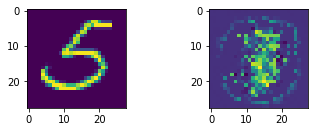

Epoch 511
[0.00171419 1.        ]
Epoch 512
[0.01844565 0.984375  ]
Epoch 513
[0.00483002 1.        ]
Epoch 514
[0.01256803 1.        ]
Epoch 515
[0.01594049 1.        ]
Epoch 516
[0.00502687 1.        ]
Epoch 517
[0.00824002 1.        ]
Epoch 518
[0.00188293 1.        ]
Epoch 519
[0.00123994 1.        ]
Epoch 520
[0.00101126 1.        ]
Saving generator model
Saved!
(28, 28)


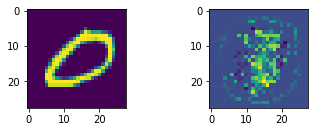

Epoch 521
[9.29479051e-04 1.00000000e+00]
Epoch 522
[4.73155684e-04 1.00000000e+00]
Epoch 523
[0.0049613 1.       ]
Epoch 524
[0.00349992 1.        ]
Epoch 525
[0.00152172 1.        ]
Epoch 526
[8.07473451e-04 1.00000000e+00]
Epoch 527
[0.00123147 1.        ]
Epoch 528
[0.00102228 1.        ]
Epoch 529
[0.00157878 1.        ]
Epoch 530
[0.00166754 1.        ]
Saving generator model
Saved!
(28, 28)


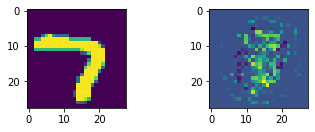

Epoch 531
[7.75867855e-04 1.00000000e+00]
Epoch 532
[0.00425676 1.        ]
Epoch 533
[0.00109255 1.        ]
Epoch 534
[0.00178784 1.        ]
Epoch 535
[0.00166696 1.        ]
Epoch 536
[9.92720394e-04 1.00000000e+00]
Epoch 537
[0.00164112 1.        ]
Epoch 538
[0.00284243 1.        ]
Epoch 539
[0.01397878 0.984375  ]
Epoch 540
[0.01045987 1.        ]
Saving generator model
Saved!
(28, 28)


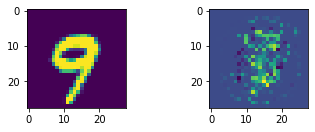

Epoch 541
[0.00327336 1.        ]
Epoch 542
[0.00232935 1.        ]
Epoch 543
[0.0039913 1.       ]
Epoch 544
[0.00280937 1.        ]
Epoch 545
[0.00217424 1.        ]
Epoch 546
[0.00204797 1.        ]
Epoch 547
[0.00253197 1.        ]
Epoch 548
[0.00165114 1.        ]
Epoch 549
[0.00497728 1.        ]
Epoch 550
[0.00232036 1.        ]
Saving generator model
Saved!
(28, 28)


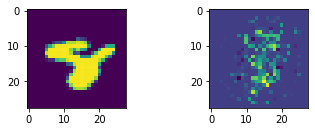

Epoch 551
[0.00322448 1.        ]
Epoch 552
[0.00472971 1.        ]
Epoch 553
[0.00272808 1.        ]
Epoch 554
[0.00383678 1.        ]
Epoch 555
[0.00250569 1.        ]
Epoch 556
[0.0024506 1.       ]
Epoch 557
[0.00255463 1.        ]
Epoch 558
[0.00434305 1.        ]
Epoch 559
[0.00269128 1.        ]
Epoch 560
[0.02036743 0.984375  ]
Saving generator model
Saved!
(28, 28)


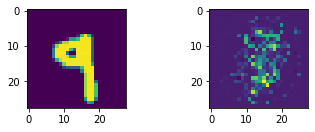

Epoch 561
[0.00312458 1.        ]
Epoch 562
[0.00529477 1.        ]
Epoch 563
[0.00373228 1.        ]
Epoch 564
[0.00452842 1.        ]
Epoch 565
[0.00503215 1.        ]
Epoch 566
[0.00424061 1.        ]
Epoch 567
[0.00945782 1.        ]
Epoch 568
[0.00655633 1.        ]
Epoch 569
[0.00289442 1.        ]
Epoch 570
[0.00488161 1.        ]
Saving generator model
Saved!
(28, 28)


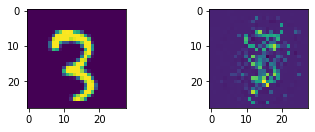

Epoch 571
[0.00568517 1.        ]
Epoch 572
[0.0092303 1.       ]
Epoch 573
[0.01130558 1.        ]
Epoch 574
[0.00972222 1.        ]
Epoch 575
[0.01069432 1.        ]
Epoch 576
[0.01334949 1.        ]
Epoch 577
[0.0069976 1.       ]
Epoch 578
[0.00445681 1.        ]
Epoch 579
[0.0040197 1.       ]
Epoch 580
[0.00198071 1.        ]
Saving generator model
Saved!
(28, 28)


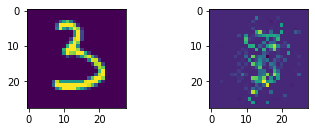

Epoch 581
[0.00177283 1.        ]
Epoch 582
[0.00508249 1.        ]
Epoch 583
[0.00237663 1.        ]
Epoch 584
[0.00893958 1.        ]
Epoch 585
[0.0015894 1.       ]
Epoch 586
[0.00150693 1.        ]
Epoch 587
[0.00498717 1.        ]
Epoch 588
[0.00232959 1.        ]
Epoch 589
[0.01943957 0.984375  ]
Epoch 590
[0.00309561 1.        ]
Saving generator model
Saved!
(28, 28)


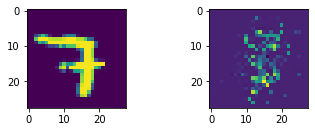

Epoch 591
[0.0041072 1.       ]
Epoch 592
[0.00480984 1.        ]
Epoch 593
[0.00446862 1.        ]
Epoch 594
[0.00394242 1.        ]
Epoch 595
[0.0043181 1.       ]
Epoch 596
[0.002181 1.      ]
Epoch 597
[0.00212733 1.        ]
Epoch 598
[0.0015103 1.       ]
Epoch 599
[0.00316571 1.        ]
Epoch 600
[0.00120727 1.        ]
Saving generator model
Saved!
(28, 28)


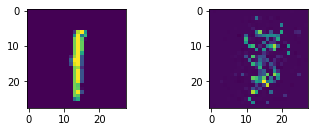

Epoch 601
[0.00132354 1.        ]
Epoch 602
[9.82485111e-04 1.00000000e+00]
Epoch 603
[0.00117132 1.        ]
Epoch 604
[0.00155644 1.        ]
Epoch 605
[0.00149995 1.        ]
Epoch 606
[0.00586877 1.        ]
Epoch 607
[0.00320293 1.        ]
Epoch 608
[0.00188197 1.        ]
Epoch 609
[0.02814332 0.984375  ]
Epoch 610
[0.00396606 1.        ]
Saving generator model
Saved!
(28, 28)


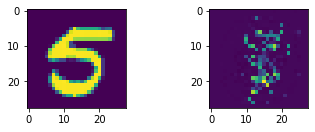

Epoch 611
[0.00476475 1.        ]
Epoch 612
[0.00388175 1.        ]
Epoch 613
[0.0079941 1.       ]
Epoch 614
[0.0074347 1.       ]
Epoch 615
[0.00441961 1.        ]
Epoch 616
[0.00284377 1.        ]
Epoch 617
[0.00234283 1.        ]
Epoch 618
[0.00269371 1.        ]
Epoch 619
[0.0018861 1.       ]
Epoch 620
[0.00154776 1.        ]
Saving generator model
Saved!
(28, 28)


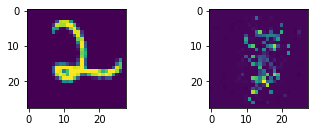

Epoch 621
[0.00299623 1.        ]
Epoch 622
[9.6715695e-04 1.0000000e+00]
Epoch 623
[0.00416602 1.        ]
Epoch 624
[0.00792126 1.        ]
Epoch 625
[0.00121781 1.        ]
Epoch 626
[0.00150684 1.        ]
Epoch 627
[0.00307992 1.        ]
Epoch 628
[0.00362573 1.        ]
Epoch 629
[0.00187713 1.        ]
Epoch 630
[0.00180352 1.        ]
Saving generator model
Saved!
(28, 28)


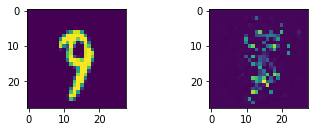

Epoch 631
[0.00241041 1.        ]
Epoch 632
[0.00181087 1.        ]
Epoch 633
[0.00209893 1.        ]
Epoch 634
[0.00350804 1.        ]
Epoch 635
[0.00247427 1.        ]
Epoch 636
[0.00200555 1.        ]
Epoch 637
[0.00159339 1.        ]
Epoch 638
[0.0033814 1.       ]
Epoch 639
[0.00159496 1.        ]
Epoch 640
[0.00197392 1.        ]
Saving generator model
Saved!
(28, 28)


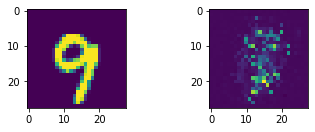

Epoch 641
[0.00130336 1.        ]
Epoch 642
[0.00501201 1.        ]
Epoch 643
[0.00161629 1.        ]
Epoch 644
[0.00213069 1.        ]
Epoch 645
[0.00315191 1.        ]
Epoch 646
[0.00203691 1.        ]
Epoch 647
[0.0016413 1.       ]
Epoch 648
[0.0031156 1.       ]
Epoch 649
[0.00240186 1.        ]
Epoch 650
[0.01075607 1.        ]
Saving generator model
Saved!
(28, 28)


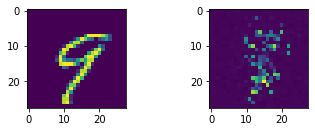

Epoch 651
[0.00219881 1.        ]
Epoch 652
[0.00203745 1.        ]
Epoch 653
[0.00210591 1.        ]
Epoch 654
[0.00211492 1.        ]
Epoch 655
[0.00282644 1.        ]
Epoch 656
[0.00226864 1.        ]
Epoch 657
[0.00190419 1.        ]
Epoch 658
[0.0023342 1.       ]
Epoch 659
[0.00237722 1.        ]
Epoch 660
[0.00130789 1.        ]
Saving generator model
Saved!
(28, 28)


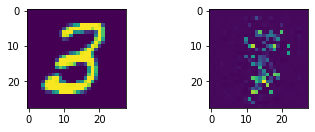

Epoch 661
[0.00228346 1.        ]
Epoch 662
[0.00137752 1.        ]
Epoch 663
[0.00759823 1.        ]
Epoch 664
[0.0028314 1.       ]
Epoch 665
[0.0019335 1.       ]
Epoch 666
[0.00145687 1.        ]
Epoch 667
[0.00161144 1.        ]
Epoch 668
[0.00908301 1.        ]
Epoch 669
[0.0021463 1.       ]
Epoch 670
[0.00248773 1.        ]
Saving generator model
Saved!
(28, 28)


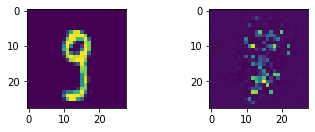

Epoch 671
[0.00226163 1.        ]
Epoch 672
[0.00188908 1.        ]
Epoch 673
[0.00180857 1.        ]
Epoch 674
[0.00282144 1.        ]
Epoch 675
[0.00148073 1.        ]
Epoch 676
[0.00161563 1.        ]
Epoch 677
[0.00318697 1.        ]
Epoch 678
[0.00131715 1.        ]
Epoch 679
[0.00115653 1.        ]
Epoch 680
[0.00462931 1.        ]
Saving generator model
Saved!
(28, 28)


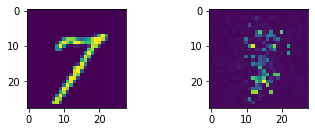

Epoch 681
[9.58809633e-04 1.00000000e+00]
Epoch 682
[0.0011542 1.       ]
Epoch 683
[0.0011993 1.       ]
Epoch 684
[9.39770736e-04 1.00000000e+00]
Epoch 685
[8.62217177e-04 1.00000000e+00]
Epoch 686
[0.00160868 1.        ]
Epoch 687
[9.9598465e-04 1.0000000e+00]
Epoch 688
[8.9533451e-04 1.0000000e+00]
Epoch 689
[8.18815388e-04 1.00000000e+00]
Epoch 690
[9.36056997e-04 1.00000000e+00]
Saving generator model
Saved!
(28, 28)


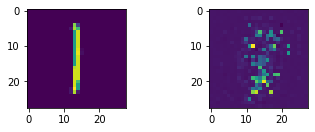

Epoch 691
[0.00378816 1.        ]
Epoch 692
[8.82825669e-04 1.00000000e+00]
Epoch 693
[0.00180144 1.        ]
Epoch 694
[0.00105881 1.        ]
Epoch 695
[0.00336086 1.        ]
Epoch 696
[0.00102812 1.        ]
Epoch 697
[0.00146008 1.        ]
Epoch 698
[0.00116782 1.        ]
Epoch 699
[0.00137581 1.        ]
Epoch 700
[0.00103919 1.        ]
Saving generator model
Saved!
(28, 28)


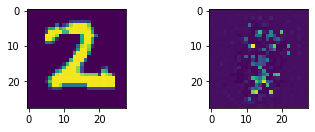

Epoch 701
[0.00181964 1.        ]
Epoch 702
[0.00226968 1.        ]
Epoch 703
[0.00148846 1.        ]
Epoch 704
[0.00111808 1.        ]
Epoch 705
[0.00549422 1.        ]
Epoch 706
[0.00154777 1.        ]
Epoch 707
[0.0011663 1.       ]
Epoch 708
[0.00109678 1.        ]
Epoch 709
[0.00121119 1.        ]
Epoch 710
[0.00110482 1.        ]
Saving generator model
Saved!
(28, 28)


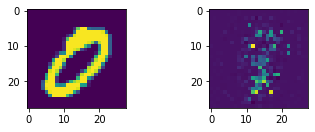

Epoch 711
[0.00165794 1.        ]
Epoch 712
[0.00142907 1.        ]
Epoch 713
[9.79888631e-04 1.00000000e+00]
Epoch 714
[0.02781083 0.984375  ]
Epoch 715
[0.00157789 1.        ]
Epoch 716
[0.00201463 1.        ]
Epoch 717
[0.00226888 1.        ]
Epoch 718
[0.00405548 1.        ]
Epoch 719
[0.00248131 1.        ]
Epoch 720
[0.00379542 1.        ]
Saving generator model
Saved!
(28, 28)


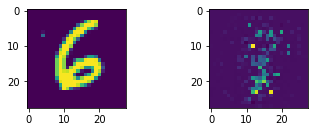

Epoch 721
[0.00209444 1.        ]
Epoch 722
[0.00232969 1.        ]
Epoch 723
[0.00151273 1.        ]
Epoch 724
[0.02184085 0.984375  ]
Epoch 725
[0.00189445 1.        ]
Epoch 726
[0.00338823 1.        ]
Epoch 727
[0.00214325 1.        ]
Epoch 728
[0.0019767 1.       ]
Epoch 729
[0.0019349 1.       ]
Epoch 730
[0.00155206 1.        ]
Saving generator model
Saved!
(28, 28)


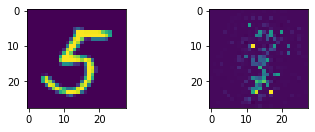

Epoch 731
[0.00153401 1.        ]
Epoch 732
[0.00122285 1.        ]
Epoch 733
[9.1086986e-04 1.0000000e+00]
Epoch 734
[7.51081226e-04 1.00000000e+00]
Epoch 735
[5.82766809e-04 1.00000000e+00]
Epoch 736
[6.37823265e-04 1.00000000e+00]
Epoch 737
[0.0010977 1.       ]
Epoch 738
[3.80712602e-04 1.00000000e+00]
Epoch 739
[0.05485965 0.984375  ]
Epoch 740
[9.39896502e-04 1.00000000e+00]
Saving generator model
Saved!
(28, 28)


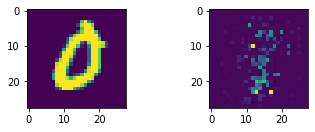

Epoch 741
[0.00141929 1.        ]
Epoch 742
[0.00192514 1.        ]
Epoch 743
[0.00213285 1.        ]
Epoch 744
[0.00209519 1.        ]
Epoch 745
[0.00226226 1.        ]
Epoch 746
[0.00193433 1.        ]
Epoch 747
[0.00163445 1.        ]
Epoch 748
[0.00134957 1.        ]
Epoch 749
[0.00107626 1.        ]
Epoch 750
[8.98543407e-04 1.00000000e+00]
Saving generator model
Saved!
(28, 28)


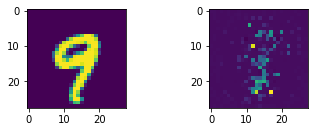

Epoch 751
[6.75943595e-04 1.00000000e+00]
Epoch 752
[5.95378916e-04 1.00000000e+00]
Epoch 753
[0.001397 1.      ]
Epoch 754
[4.76801953e-04 1.00000000e+00]
Epoch 755
[3.80341539e-04 1.00000000e+00]
Epoch 756
[3.44711245e-04 1.00000000e+00]
Epoch 757
[4.59505813e-04 1.00000000e+00]
Epoch 758
[3.20019804e-04 1.00000000e+00]
Epoch 759
[2.64294743e-04 1.00000000e+00]
Epoch 760
[9.46073167e-04 1.00000000e+00]
Saving generator model
Saved!
(28, 28)


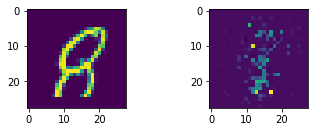

Epoch 761
[4.05691084e-04 1.00000000e+00]
Epoch 762
[2.30340057e-04 1.00000000e+00]
Epoch 763
[2.15381904e-04 1.00000000e+00]
Epoch 764
[3.75523698e-04 1.00000000e+00]
Epoch 765
[8.09072197e-04 1.00000000e+00]
Epoch 766
[2.20957062e-04 1.00000000e+00]
Epoch 767
[2.15701937e-04 1.00000000e+00]
Epoch 768
[2.14828029e-04 1.00000000e+00]
Epoch 769
[2.13202318e-04 1.00000000e+00]
Epoch 770
[2.54856535e-04 1.00000000e+00]
Saving generator model
Saved!
(28, 28)


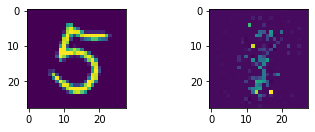

Epoch 771
[2.03634513e-04 1.00000000e+00]
Epoch 772
[5.21636844e-04 1.00000000e+00]
Epoch 773
[1.9092221e-04 1.0000000e+00]
Epoch 774
[0.00130089 1.        ]
Epoch 775
[2.08049084e-04 1.00000000e+00]
Epoch 776
[2.43824299e-04 1.00000000e+00]
Epoch 777
[3.55375509e-04 1.00000000e+00]
Epoch 778
[2.29954758e-04 1.00000000e+00]
Epoch 779
[2.82576559e-04 1.00000000e+00]
Epoch 780
[2.57554781e-04 1.00000000e+00]
Saving generator model
Saved!
(28, 28)


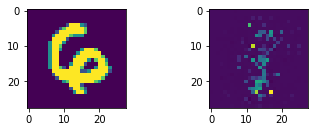

Epoch 781
[2.3429664e-04 1.0000000e+00]
Epoch 782
[4.94363543e-04 1.00000000e+00]
Epoch 783
[2.33866397e-04 1.00000000e+00]
Epoch 784
[2.41000276e-04 1.00000000e+00]
Epoch 785
[2.31971831e-04 1.00000000e+00]
Epoch 786
[0.00196073 1.        ]
Epoch 787
[3.02287208e-04 1.00000000e+00]
Epoch 788
[2.83711017e-04 1.00000000e+00]
Epoch 789
[0.00136472 1.        ]
Epoch 790
[3.07616132e-04 1.00000000e+00]
Saving generator model
Saved!
(28, 28)


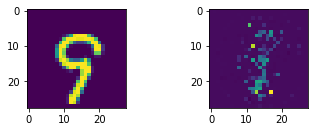

Epoch 791
[5.68852847e-04 1.00000000e+00]
Epoch 792
[0.0029058 1.       ]
Epoch 793
[4.19376601e-04 1.00000000e+00]
Epoch 794
[4.66635251e-04 1.00000000e+00]
Epoch 795
[4.9581082e-04 1.0000000e+00]
Epoch 796
[0.00408897 1.        ]
Epoch 797
[6.51101316e-04 1.00000000e+00]
Epoch 798
[7.25518827e-04 1.00000000e+00]
Epoch 799
[8.90069539e-04 1.00000000e+00]
Epoch 800
[7.64670631e-04 1.00000000e+00]
Saving generator model
Saved!
(28, 28)


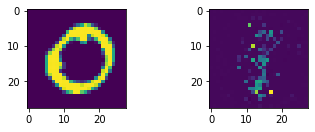

Epoch 801
[8.0562842e-04 1.0000000e+00]
Epoch 802
[7.42891794e-04 1.00000000e+00]
Epoch 803
[0.0012817 1.       ]
Epoch 804
[6.77379808e-04 1.00000000e+00]
Epoch 805
[6.26749707e-04 1.00000000e+00]
Epoch 806
[7.42295568e-04 1.00000000e+00]
Epoch 807
[5.42880574e-04 1.00000000e+00]
Epoch 808
[0.00107517 1.        ]
Epoch 809
[4.88462618e-04 1.00000000e+00]
Epoch 810
[4.52657584e-04 1.00000000e+00]
Saving generator model
Saved!
(28, 28)


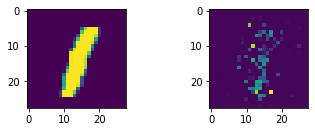

Epoch 811
[4.82548159e-04 1.00000000e+00]
Epoch 812
[0.00277644 1.        ]
Epoch 813
[8.00355687e-04 1.00000000e+00]
Epoch 814
[4.89909164e-04 1.00000000e+00]
Epoch 815
[6.14887198e-04 1.00000000e+00]
Epoch 816
[5.18563436e-04 1.00000000e+00]
Epoch 817
[0.00105001 1.        ]
Epoch 818
[5.36840329e-04 1.00000000e+00]
Epoch 819
[6.29974493e-04 1.00000000e+00]
Epoch 820
[5.20059001e-04 1.00000000e+00]
Saving generator model
Saved!
(28, 28)


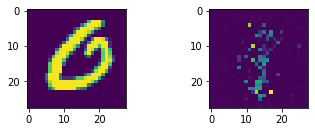

Epoch 821
[0.00158226 1.        ]
Epoch 822
[5.30564347e-04 1.00000000e+00]
Epoch 823
[5.35114441e-04 1.00000000e+00]
Epoch 824
[6.75747913e-04 1.00000000e+00]
Epoch 825
[5.21009044e-04 1.00000000e+00]
Epoch 826
[0.00214082 1.        ]
Epoch 827
[5.59572479e-04 1.00000000e+00]
Epoch 828
[5.69718418e-04 1.00000000e+00]
Epoch 829
[5.84283292e-04 1.00000000e+00]
Epoch 830
[5.79853302e-04 1.00000000e+00]
Saving generator model
Saved!
(28, 28)


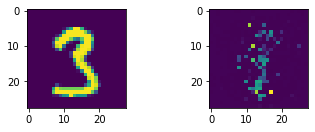

Epoch 831
[5.56813059e-04 1.00000000e+00]
Epoch 832
[6.15725236e-04 1.00000000e+00]
Epoch 833
[0.03645376 0.984375  ]
Epoch 834
[0.00187158 1.        ]
Epoch 835
[0.01029328 1.        ]
Epoch 836
[0.00668276 1.        ]
Epoch 837
[0.00703905 1.        ]
Epoch 838
[0.00523851 1.        ]
Epoch 839
[0.00315545 1.        ]
Epoch 840
[0.00167671 1.        ]
Saving generator model
Saved!
(28, 28)


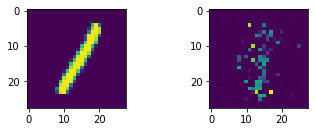

Epoch 841
[9.53539968e-04 1.00000000e+00]
Epoch 842
[5.76655438e-04 1.00000000e+00]
Epoch 843
[5.97918421e-04 1.00000000e+00]
Epoch 844
[0.00593734 1.        ]
Epoch 845
[3.53539609e-04 1.00000000e+00]
Epoch 846
[6.44987769e-04 1.00000000e+00]
Epoch 847
[4.26585701e-04 1.00000000e+00]
Epoch 848
[0.00165359 1.        ]
Epoch 849
[6.87645967e-04 1.00000000e+00]
Epoch 850
[6.33199239e-04 1.00000000e+00]
Saving generator model
Saved!
(28, 28)


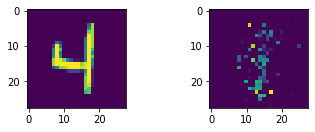

Epoch 851
[6.96524455e-04 1.00000000e+00]
Epoch 852
[7.70167515e-04 1.00000000e+00]
Epoch 853
[7.94517446e-04 1.00000000e+00]
Epoch 854
[8.26718893e-04 1.00000000e+00]
Epoch 855
[7.98145899e-04 1.00000000e+00]
Epoch 856
[7.91722794e-04 1.00000000e+00]
Epoch 857
[0.00114197 1.        ]
Epoch 858
[0.0030985 1.       ]
Epoch 859
[0.0033838 1.       ]
Epoch 860
[0.00595068 1.        ]
Saving generator model
Saved!
(28, 28)


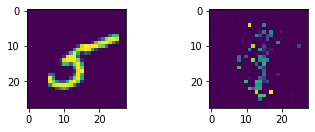

Epoch 861
[0.00262824 1.        ]
Epoch 862
[0.00776941 1.        ]
Epoch 863
[0.00431302 1.        ]
Epoch 864
[0.00367674 1.        ]
Epoch 865
[0.00240895 1.        ]
Epoch 866
[0.00140193 1.        ]
Epoch 867
[8.50910649e-04 1.00000000e+00]
Epoch 868
[0.0256875 0.984375 ]
Epoch 869
[0.00283323 1.        ]
Epoch 870
[0.01889978 0.984375  ]
Saving generator model
Saved!
(28, 28)


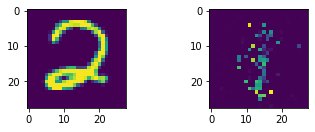

Epoch 871
[0.01871985 1.        ]
Epoch 872
[0.01046868 1.        ]
Epoch 873
[0.00414569 1.        ]
Epoch 874
[0.00114491 1.        ]
Epoch 875
[0.00185459 1.        ]
Epoch 876
[0.00703978 1.        ]
Epoch 877
[0.01743259 0.984375  ]
Epoch 878
[0.00135848 1.        ]
Epoch 879
[0.00430741 1.        ]
Epoch 880
[0.00448703 1.        ]
Saving generator model
Saved!
(28, 28)


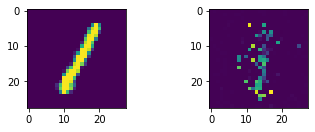

Epoch 881
[0.00633896 1.        ]
Epoch 882
[0.00386348 1.        ]
Epoch 883
[0.00358581 1.        ]
Epoch 884
[0.00230726 1.        ]
Epoch 885
[9.1317838e-04 1.0000000e+00]
Epoch 886
[6.57527393e-04 1.00000000e+00]
Epoch 887
[0.09304845 0.984375  ]
Epoch 888
[0.00349039 1.        ]
Epoch 889
[0.00631671 1.        ]
Epoch 890
[0.00525621 1.        ]
Saving generator model
Saved!
(28, 28)


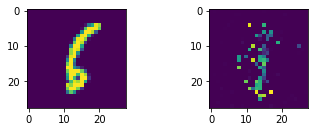

Epoch 891
[0.00506724 1.        ]
Epoch 892
[0.00223925 1.        ]
Epoch 893
[0.00109997 1.        ]
Epoch 894
[6.84229177e-04 1.00000000e+00]
Epoch 895
[0.00904399 1.        ]
Epoch 896
[7.38218156e-04 1.00000000e+00]
Epoch 897
[0.00473432 1.        ]
Epoch 898
[0.00220172 1.        ]
Epoch 899
[0.00245615 1.        ]
Epoch 900
[0.00230363 1.        ]
Saving generator model
Saved!
(28, 28)


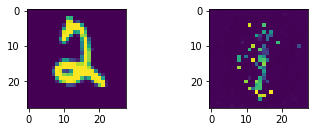

Epoch 901
[0.00182443 1.        ]
Epoch 902
[0.00116005 1.        ]
Epoch 903
[7.30841168e-04 1.00000000e+00]
Epoch 904
[5.2397069e-04 1.0000000e+00]
Epoch 905
[0.03088027 0.984375  ]
Epoch 906
[0.00327913 1.        ]
Epoch 907
[0.00610343 1.        ]
Epoch 908
[0.00574124 1.        ]
Epoch 909
[0.00211699 1.        ]
Epoch 910
[0.00124836 1.        ]
Saving generator model
Saved!
(28, 28)


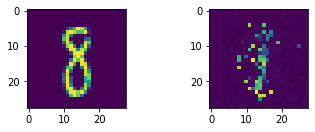

Epoch 911
[0.03444549 0.984375  ]
Epoch 912
[0.00279412 1.        ]
Epoch 913
[0.0045879 1.       ]
Epoch 914
[0.00336344 1.        ]
Epoch 915
[0.00180092 1.        ]
Epoch 916
[8.94062723e-04 1.00000000e+00]
Epoch 917
[0.02727343 0.984375  ]
Epoch 918
[0.00226798 1.        ]
Epoch 919
[0.00319642 1.        ]
Epoch 920
[0.00284954 1.        ]
Saving generator model
Saved!
(28, 28)


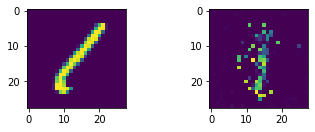

Epoch 921
[0.00162097 1.        ]
Epoch 922
[9.16071768e-04 1.00000000e+00]
Epoch 923
[5.30303581e-04 1.00000000e+00]
Epoch 924
[3.14614989e-04 1.00000000e+00]
Epoch 925
[2.33642623e-04 1.00000000e+00]
Epoch 926
[0.00342389 1.        ]
Epoch 927
[2.77996272e-04 1.00000000e+00]
Epoch 928
[7.86246674e-04 1.00000000e+00]
Epoch 929
[5.95972961e-04 1.00000000e+00]
Epoch 930
[0.02216085 0.984375  ]
Saving generator model
Saved!
(28, 28)


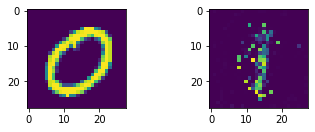

Epoch 931
[0.08121222 0.984375  ]
Epoch 932
[0.01488527 1.        ]
Epoch 933
[0.00116352 1.        ]
Epoch 934
[1.94930617e-04 1.00000000e+00]
Epoch 935
[2.24342911e-05 1.00000000e+00]
Epoch 936
[7.72929207e-06 1.00000000e+00]
Epoch 937
[5.10316727e-06 1.00000000e+00]
Epoch 938
[7.99211584e-04 1.00000000e+00]
Epoch 939
[2.8120093e-04 1.0000000e+00]
Epoch 940
[2.45505829e-04 1.00000000e+00]
Saving generator model
Saved!
(28, 28)


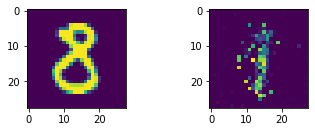

Epoch 941
[2.46640741e-06 1.00000000e+00]
Epoch 942
[0.05217453 0.984375  ]
Epoch 943
[5.94393678e-05 1.00000000e+00]
Epoch 944
[0.00272464 1.        ]
Epoch 945
[0.00190148 1.        ]
Epoch 946
[0.00770132 1.        ]
Epoch 947
[0.00625579 1.        ]
Epoch 948
[0.00328047 1.        ]
Epoch 949
[8.05516553e-04 1.00000000e+00]
Epoch 950
[3.85474195e-04 1.00000000e+00]
Saving generator model
Saved!
(28, 28)


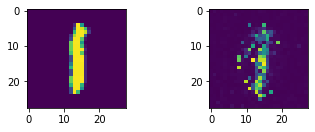

Epoch 951
[1.82260468e-04 1.00000000e+00]
Epoch 952
[0.00976903 1.        ]
Epoch 953
[6.7129236e-04 1.0000000e+00]
Epoch 954
[0.0070826 1.       ]
Epoch 955
[0.22302309 0.921875  ]
Epoch 956
[4.11584588e-05 1.00000000e+00]
Epoch 957
[2.57282125e-05 1.00000000e+00]
Epoch 958
[0.37667257 0.9375    ]
Epoch 959
[0.14058986 0.96875   ]
Epoch 960
[1.90545403 0.71875   ]
Saving generator model
Saved!
(28, 28)


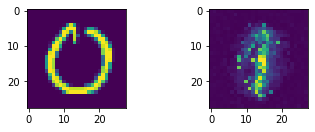

Epoch 961
[0.0055084 1.       ]
Epoch 962
[1.44930673 0.78125   ]
Epoch 963
[0.73018227 0.90625   ]
Epoch 964
[0.19853179 0.90625   ]
Epoch 965
[0.46299822 0.921875  ]
Epoch 966
[1.48720186e-04 1.00000000e+00]
Epoch 967
[0.28088945 0.953125  ]
Epoch 968
[0.59094393 0.890625  ]
Epoch 969
[0.57214606 0.859375  ]
Epoch 970
[0.13991498 0.9375    ]
Saving generator model
Saved!
(28, 28)


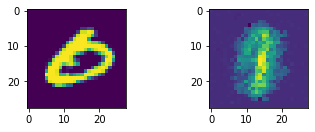

Epoch 971
[5.75881078 0.515625  ]
Epoch 972
[0.35007721 0.921875  ]
Epoch 973
[3.77203202 0.625     ]
Epoch 974
[4.98246098 0.53125   ]
Epoch 975
[1.46640193 0.796875  ]
Epoch 976
[0.01422404 1.        ]
Epoch 977
[1.69305225e-08 1.00000000e+00]
Epoch 978
[0.82044566 0.5625    ]
Epoch 979
[7.06892989e-09 1.00000000e+00]
Epoch 980
[0.00268594 1.        ]
Saving generator model
Saved!
(28, 28)


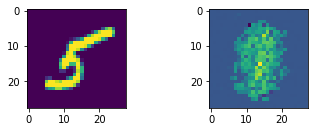

Epoch 981
[0.71745014 0.90625   ]
Epoch 982
[1.1924423 0.828125 ]
Epoch 983
[1.04319263 0.890625  ]
Epoch 984
[0.0460409 0.984375 ]
Epoch 985
[2.21853907e-06 1.00000000e+00]
Epoch 986
[9.71872651e-05 1.00000000e+00]
Epoch 987
[3.36952981e-08 1.00000000e+00]
Epoch 988
[9.5009915e-06 1.0000000e+00]
Epoch 989
[0.03548891 0.96875   ]
Epoch 990
[0.29372096 0.90625   ]
Saving generator model
Saved!
(28, 28)


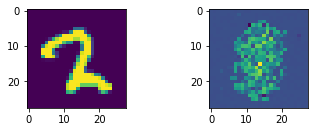

Epoch 991
[0.05837165 0.96875   ]
Epoch 992
[0.00628931 1.        ]
Epoch 993
[0.00876445 1.        ]
Epoch 994
[0.34566983 0.953125  ]
Epoch 995
[0.26161661 0.953125  ]
Epoch 996
[0.79793513 0.640625  ]
Epoch 997
[0.17013913 0.9375    ]
Epoch 998
[1.78704948 0.8125    ]
Epoch 999
[0.79468797 0.90625   ]


In [224]:
##Compile Discriminator and generator

discriminator = Discriminator(input_image_shape=(28,28,1)).Discriminator_model()
discriminator.compile(loss='binary_crossentropy',
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=['accuracy'])

#build and compile our Discriminator, pick the loss function

#SInce we are only generating (faking) images, let us not track any metrics.
generator=Generator(input_dimensions=(28,28,1),noise_vector_shape=(100,)).Generator_model()
generator.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=1e-4))

discriminator.trainable=False
##Create a model equivalent to GAN structure - combine generator and discriminator 
#Here we combined the models and also set our loss function and optimizer. 
#Again, we are only training the generator here. 
#The ultimate goal here is for the Generator to fool the Discriminator.  
# The combined model  (stacked generator and discriminator) takes
# noise as input => generates images => determines validity
input_GAN_system=keras.Input(shape=(100,))
generated_image=generator(input_GAN_system)
validat_image= discriminator(generated_image)
GAN_combination = keras.Model(input_GAN_system, validat_image)
GAN_combination.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=1e-4))
GAN_combination.summary()


train_GAN(x_train,discriminator,generator,batch_size)





In [124]:
from types import GeneratorType
##Test the generator


Generator= keras.models.load_model("./generators/gen_epoch_10.h5")

(28, 28)


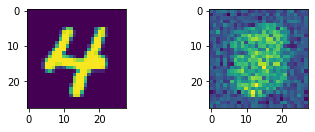

In [128]:
def plot_images(Generator=generator):
  idx = np.random.randint(0, x_train.shape[0], half_batch)
  imgs = x_train[idx][0]
  plt.subplot(2,2,1)
  plt.imshow(imgs)

  noise = np.random.normal(0, 1, (1, 100))
  gen_imgs = Generator.predict(noise)
  print(gen_imgs[0][:,:,-1].shape)
  plt.subplot(2,2,2)
  plt.imshow(gen_imgs[0][:,:,-1])
  plt.show()

plot_images(Generator)